## Generating synthetic datasets for the six common regulatory architectures

Required packages:

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tregs.mpl_pboc import plotting_style

plt.rcParams.update({'font.size': 12})
plotting_style()

fdir = '../data/'

### 0. Loading input data

To construct synthetic datasets, we first need to load the sequences and the energy matrices. Let us first read in the sequence of the entire *E. coli* genome.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

Next, we load the following dataframe, which contains information about the transcription start site (tss) of each gene.

In [3]:
df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
df.head()

,gene,promoter,gene_position,direction,tss,evidence
0,accA,accAp2,208621.0,+,208326.0,"[""none"", ""EXP""]"
1,accA,accAp1,208621.0,+,208411.0,"[""COMP"", ""EXP"", ""EXP""]"
2,accB,accBp1,3405436.0,+,3405140.0,"[""COMP"", ""EXP"", ""COMP""]"
3,accC,accBp1,3405917.0,+,3405140.0,"[""COMP"", ""EXP"", ""COMP""]"
4,accB,accBp2,3405436.0,+,3405172.0,"[""none"", ""EXP""]"


In this notebook, we would like to construct synthetic datasets for the lacZ promoter, so we access TSS for lacZ from the dataframe. We use the function `get_regulatory_region` in the `tregs` package to access the 160 base-pair sequence around the TSS (115 base-pair upstream of the TSS and 45 base-pair downstream of the TSS).

In [4]:
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [5]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [6]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [7]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

And finally we read in and normalize the experimentally determined energy matrix for the CRP activator (Kinney et al, 2010) (https://www.pnas.org/doi/full/10.1073/pnas.1004290107). The original energy matrix reported in the paper contains energy terms in the unit of $kcal / mol$, here we convert them to $k_BT$ units.

In [8]:
crp_emat_raw = pd.read_table(fdir + 'energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62
crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site)

### 1. Constitutive promoter

To simulate synthetic datasets, we use a pre-written function `sim` in the `tregs` package. The function first generates a library of promoter variants with a given library size and mutation rate. Based on the binding site sequence of each promoter variant, the function uses thermodynamic models to calculate the predicted RNA count. The final list of sequences and normalized RNA counts are stored in a dataframe. 

To run the `sim` function, we specify the promoter sequence, the architecture of the interest, the binding site sequences, as well as other relevant parameters needed for the thermodynamic model.  For a constitutive promoter, the thermodynamic model requires input parameters on the number of non-specific binding sites (`n_NS`), the copy number of RNAP (`n_p`), and the binding energy of RNAP at the wild-type promoter (`ep_wt`).

In [9]:
n_NS = len(genome)
n_p = 5000
ep_wt = -5

df = tregs.simulate.sim(promoter, tregs.simulate.constitutive_pbound, [rnap_site],
                        *[n_NS, n_p, rnap_emat], scaling_factor=10**6)

Given the dataframe containing the promoter variants and the associated RNA counts, we can calculate and plot the information footprint using the `plot_footprint` function from the `tregs` package.

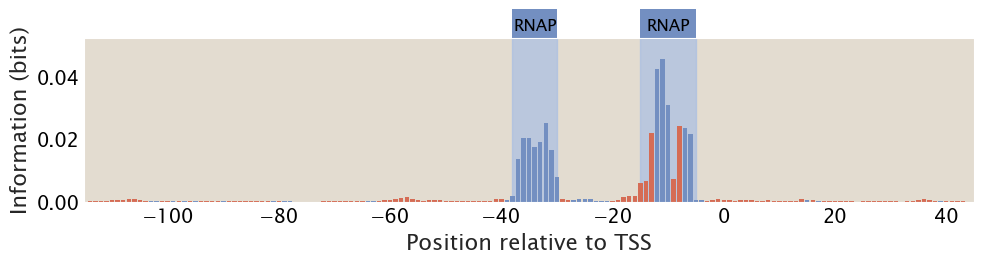

In [10]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-115, 45),
                               outfile='../plots/fig3/constitutive.pdf')

Alternatively, to examine the effects of individual mutations on expression levels, we can also plot the expression shift matrix using the `plot_exshift` function from the `tregs` package.

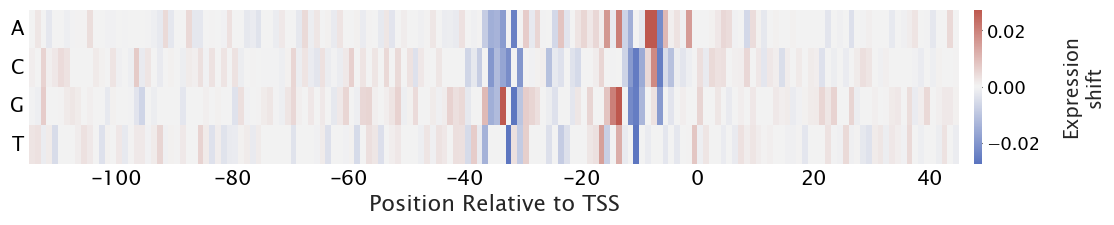

In [11]:
tregs.footprint.plot_exshift(promoter, df,
             outfile='../plots/fig3/constitutive_exshift_matrix.pdf')

### 2. Simple repression

The code for generating synthetic datasets and plotting summarry statistics is very similar for the other regulatory architecture.

For a promoter with the simple repression regulatory architecture, we need the following parameters:
- the number of non-specific binding sites (`n_NS`)
- copy number of RNAP (`n_p`)
- copy number of the repressor (`n_r`)
- binding energy of the RNAP at the wild-type binding site (`ep_wt`)
- binding energy of the repressor at the wild-type binding site (`er_wt`)

Here, we use the known copy number and binding energy of the lacI repressor.

In [12]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

From the synthetic dataset for the simple repression promoter, we plot the information footprint and expression shift matrix.

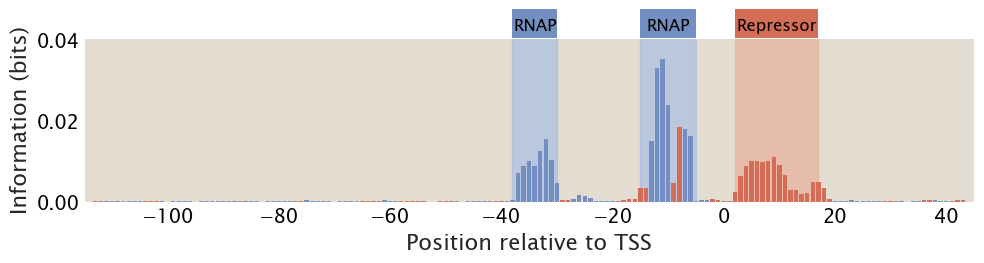

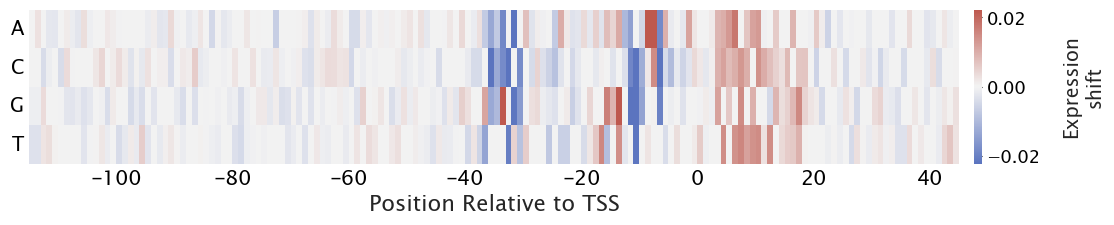

In [13]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'Repressor')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/fig3/simrep.pdf')

tregs.footprint.plot_exshift(promoter, df,
                             outfile='../plots/fig3/simrep_exshift_matrix.pdf')

### 3. Simple activation

For a promoter with the simple activator regulatory architecture, we need the following parameters:
- the number of non-specific binding sites (`n_NS`)
- copy number of RNAP (`n_p`)
- copy number of the activator (`n_a`)
- binding energy of the RNAP at the wild-type binding site (`ep_wt`)
- binding energy of the activator at the wild-type binding site (`ea_wt`)
- interaction energy between the RNAP and the activator (`e_ap`)

Here we use CRP binding at the lacZYA promoter as a case study.

In [14]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -5
ea_wt = -12
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

From the synthetic dataset for the simple activation promoter, we plot the information footprint and expression shift matrix.

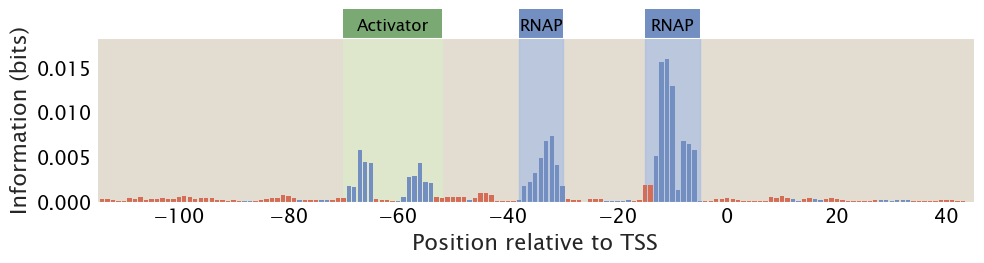

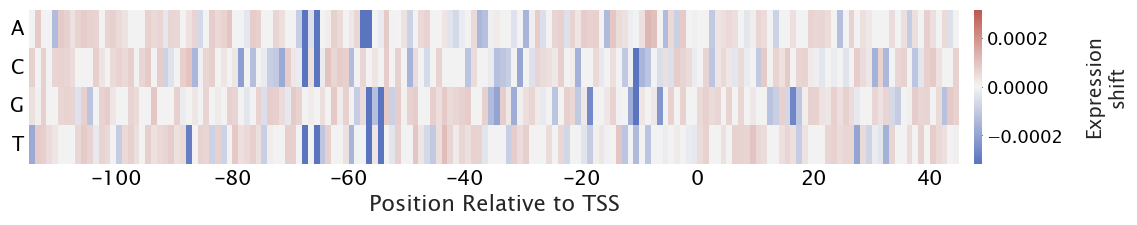

In [15]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'Activator')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/fig3/simact.pdf')

tregs.footprint.plot_exshift(promoter, df,
                             outfile='../plots/fig3/simact_exshift_matrix.pdf')

### 4. Repression-activation

Next, we build a synthetic dataset for a promoter regulated by both a repressor and an activator. Here, instead of using experimentally determined energy matrices, we generate random energy matrices based on promoter sequences using the function `generate_emap` from the `tregs` library. For the random energy matrices, we assign the a binding energy of $0\ k_BT$ for wild-type base identities at each position and a positive binding energy for mutant base identities according to a uniform distribution.

In [16]:
act_site = promoter[(115 - 110 + 40):(115 - 110 + 55)]
rep_site = promoter[(115+5):(115+20)]

act_emat = tregs.simulate.generate_emap(act_site, max_mut_energy=1)
rep_emat = tregs.simulate.generate_emap(rep_site, max_mut_energy=1)

For a promoter with the repression-activation regulatory architecture, we need the following parameters:

- the number of non-specific binding sites (`n_NS`)
- copy number of RNAP (`n_p`)
- copy number of the repressor (`n_r`)
- copy number of the activator (`n_a`)
- binding energy of the RNAP at the wild-type binding site (`ep_wt`)
- binding energy of the repressor at the wild-type binding site (`er_wt`)
- binding energy of the activator at the wild-type binding site (`er_wt`)
- interaction energy between the RNAP and the activator (`e_int`)

In [17]:
n_NS = len(genome)
n_p, n_r, n_a = 5000, 50, 50
ep_wt, er_wt, ea_wt = -2, -15, -12
e_int = -8

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, act_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, act_emat, ep_wt, er_wt, ea_wt, e_int], scaling_factor=10*6)

From the synthetic dataset for the repression-activation promoter, we plot the information footprint and expression shift matrix.

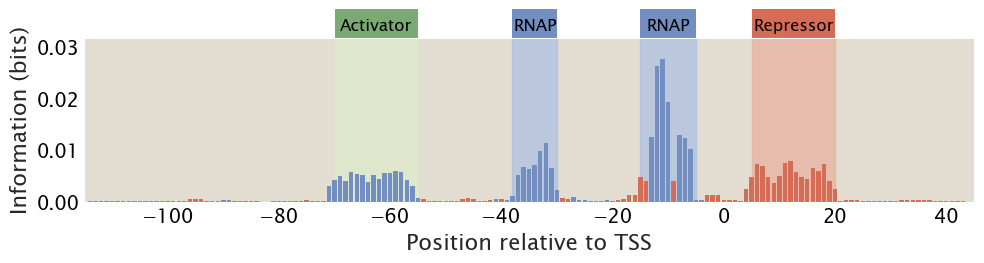

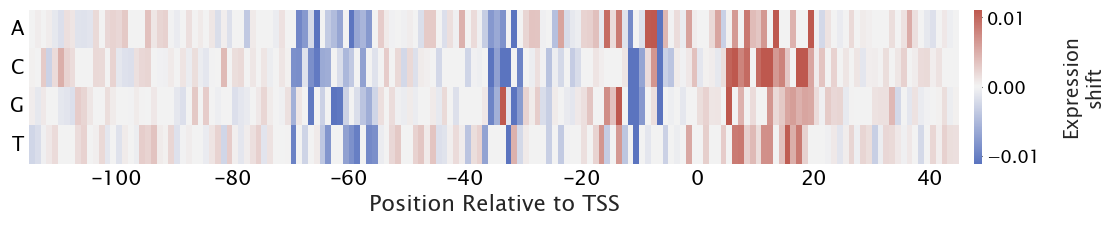

In [18]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'),
                 (-70, -55, 'A', 'Activator'), (5, 20, 'R', 'Repressor')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/fig3/repact.pdf')

tregs.footprint.plot_exshift(promoter, df,
                             outfile='../plots/fig3/repact_exshift_matrix.pdf')

### 5. Double repression

To build a synthetic dataset for a promoter regulated by two repressors, again we randomly generate energy matrices for the two repressors.

In [19]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = tregs.simulate.generate_emap(rep1_site, max_mut_energy=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, max_mut_energy=1)

For a promoter with the repression-activation regulatory architecture, we need the following parameters:

- the number of non-specific binding sites (`n_NS`)
- copy number of RNAP (`n_p`)
- copy number of the first repressor (`n_r1`)
- copy number of the second repressor (`n_r2`)
- binding energy of the RNAP at the wild-type binding site (`ep_wt`)
- binding energy of the first repressor at the wild-type binding site (`er1_wt`)
- binding energy of the second repressor at the wild-type binding site (`er2_wt`)
- interaction energy between the two repressors (`e_int`)

In [20]:
n_NS = len(genome)
n_p, n_r1, n_r2 = 4600, 15, 15
ep_wt, er1_wt, er2_wt = -5, -12, -12
e_int = -5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

From the synthetic dataset for the double-repression promoter, we plot the information footprint and expression shift matrix.

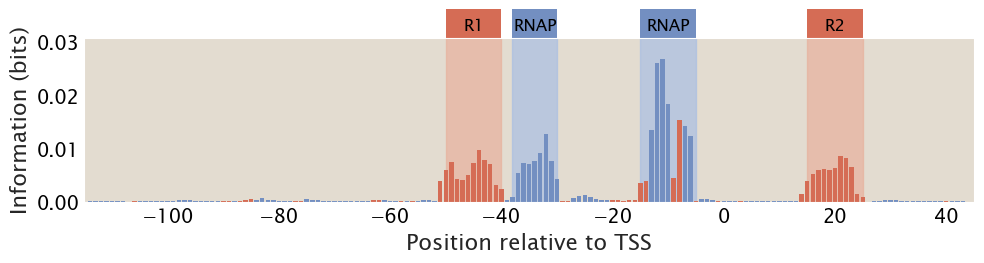

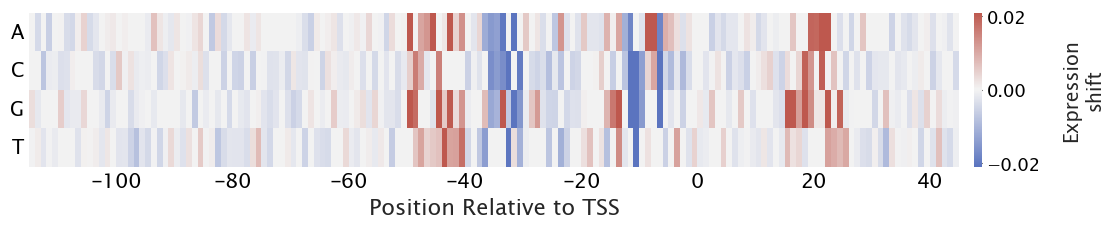

In [21]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-50, -40, 'R', 'R1'), (15, 25, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/fig3/double_rep.pdf')

tregs.footprint.plot_exshift(promoter, df,
                             outfile='../plots/fig3/doublerep_exshift_matrix.pdf')

### Double activation

To build a synthetic dataset for a promoter regulated by two activators, again we randomly generate energy matrices for the two activators.

In [17]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

For a promoter with the repression-activation regulatory architecture, we need the following parameters:

- the number of non-specific binding sites (`n_NS`)
- copy number of RNAP (`n_p`)
- copy number of the first activator (`n_a1`)
- copy number of the second activator (`n_a2`)
- binding energy of the RNAP at the wild-type binding site (`ep_wt`)
- binding energy of the first activator at the wild-type binding site (`ea1_wt`)
- binding energy of the second activator at the wild-type binding site (`ea2_wt`)
- interaction energy between the RNAP and the first activator (`e_int_pa1`)
- interaction energy between the RNAP and the second activator (`e_int_pa2`)
- interaction energy between the two activators (`e_int_a1a2`)

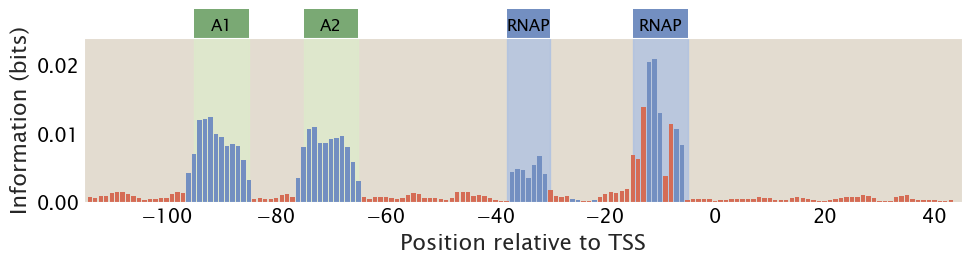

In [18]:
n_NS = len(genome)
n_p, n_a1, n_a2 = 4600, 50, 50
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, 'OR'], scaling_factor=100)

From the synthetic dataset for the double-activation promoter, we plot the information footprint and expression shift matrix.

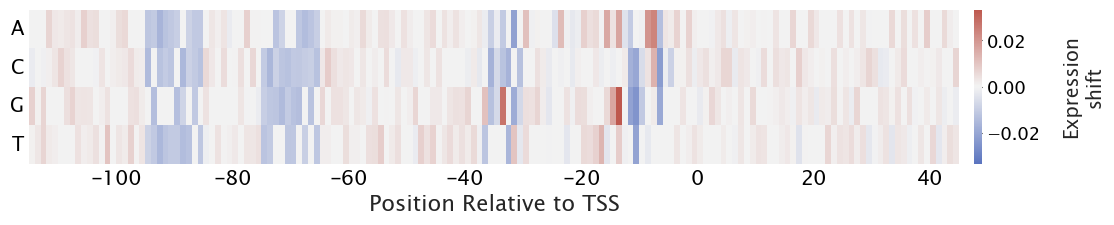

In [19]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/fig3/double_act.pdf')

tregs.footprint.plot_exshift(promoter, df,
                             outfile='../plots/fig3/doubleact_exshift_matrix.pdf')